In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightComponents.Control
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using ControlSystems
using RobustAndOptimalControl

In [2]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#same mass in all cases
fwd_cg_pld = C172.PayloadU(m_pilot = 100, m_copilot = 100, m_baggage = 0)
aft_cg_pld = C172.PayloadU(m_pilot = 50, m_copilot = 50, m_baggage = 100)
mid_cg_pld = C172.PayloadU(m_pilot = 75, m_copilot = 75, m_baggage = 50)

design_condition_1 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 25.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 1.0,
    payload = mid_cg_pld)

design_condition_2 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 55.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 0.0,
    payload = mid_cg_pld)

thr_ele_MIMO = named_ss(ac, design_condition_1; model = :lon);

## 1. Pitch Rate

In [3]:
P_e2q = thr_ele_MIMO[:q, :elevator_cmd]
P_e2q_simp = minreal(P_e2q, 1e-2)
zeros_q = zpkdata(P_e2q_simp)[1][1]
ωn_q, ζ_q, poles_q = damp(P_e2q_simp)
zeros_q |> display
poles_q |> display
ωn_q |> display
ζ_q |> display

5-element Vector{ComplexF64}:
    -49.672496161064196 + 0.0im
     -9.197147739490314 + 0.0im
 -6.8344320717078105e-6 + 0.0im
   -0.25177348459934334 + 0.0im
    -0.8146895569717002 + 0.0im

8-element Vector{ComplexF64}:
 -0.05922020396774893 + 0.4562714825288754im
 -0.05922020396774893 - 0.4562714825288754im
  -2.7189215156606927 + 3.667035115995521im
  -2.7189215156606927 - 3.667035115995521im
   -9.195200934025204 + 0.0im
   -18.84955592153878 + 25.13274122871831im
   -18.84955592153878 - 25.13274122871831im
   -49.46371128963316 + 0.0im

8-element Vector{Float64}:
  0.46009857457623105
  0.46009857457623105
  4.565049917609546
  4.565049917609546
  9.195200934025204
 31.415926535897917
 31.415926535897917
 49.46371128963316

8-element Vector{Float64}:
 0.12871199182108553
 0.12871199182108553
 0.5955951336200144
 0.5955951336200144
 1.0
 0.6000000000000009
 0.6000000000000009
 1.0

We have:
- A very fast real pole, corresponding to the AoA filter
- Two pairs of very fast complex poles, corresponding to the throttle and elevator actuators
- A fast real pole, corresponding to the powerplant response (in particular, the propeller moment of inertia)
- A pair of fast, well damped complex poles, corresponding to the short period mode
- A pair of slow, lightly damped complex poles, corresponding to the phugoid mode

We can see the following effects on the phugoid and short period modes:
- Moving the CG forward does not significantly affect the phugoid mode, and increases short period frequency.
- Increasing altitude slightly decreases phugoid damping, decreases short period frequency and decreases short period damping.
- Increasing airspeed significantly decreases phugoid frequency, significantly increases short period frequency and increases short period damping.

The most impactful variable across the envelope is airspeed. Short period frequency ranges from about 4 rad/s at low airspeeds to 10 rad/s at high airspeeds. Therefore, it is the prime candidate for gain scheduling, followed by altitude. Other than that, we have a zero at the origin, which means that a constant pitch rate cannot be sustained by a constant elevator deflection. This results in the negative slope of  low frequency gain in the Bode plot and the Nyquist curve going into the origin for $\omega \rightarrow 0$.

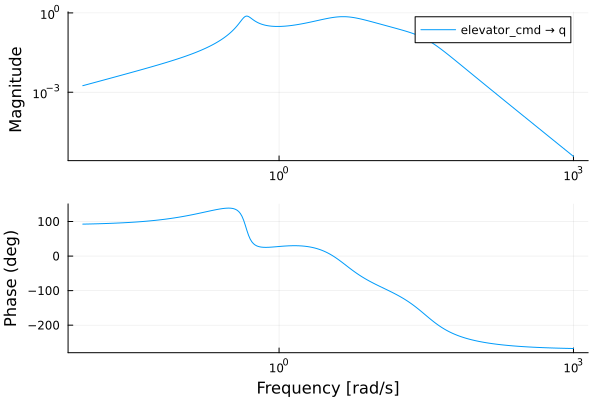

In [4]:
bodeplot(P_e2q)

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

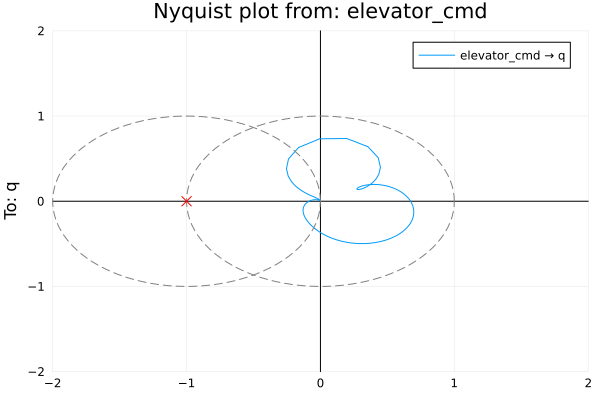

In [5]:
nyquistplot(P_e2q; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

From the above, we expect the steady-state error for a step input to be 1, which can be confirmed by the final value theorem.

In [6]:
#error transfer function for a unit feedback closed loop and a unit step input
ε_e2q_cl = 1/(1+tf(P_e2q))
@assert isstable(ε_e2q_cl) #ensure final value theorem is applicable
@show ε_e2q_cl(0)

ε_e2q_cl(0) = [0.9999987959550699;;]


1×1 Matrix{Float64}:
 0.9999987959550699

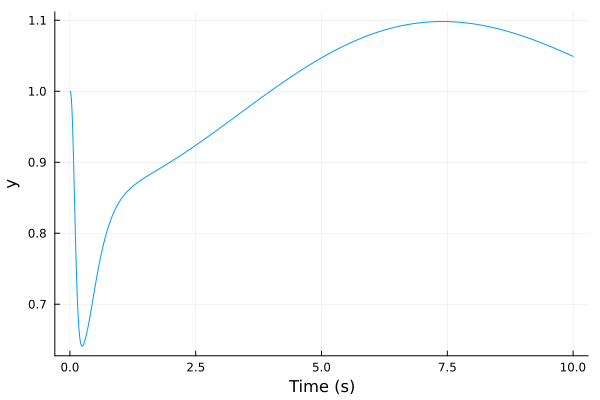

In [7]:
step(ε_e2q_cl, 10) |> plot

We need to add two integrators in the loop transfer function in order to achieve a type-1 system and eliminate steady-state error. One of them will be a standalone integrator, the other one will come from the PID. Now let's try to optimize the PID design. Our target plant for the optimization is the elevator to pitch rate transfer function P_e2q in series with the standalone integrator. Once the optimization is done, this integrator will be moved to the compensator.


In [515]:
#our optimization target plant is NOT simply P_e2q; it must already include the
#integrator
q_int = tf(1, [1, 0]) |> ss
P_q_opt = series(q_int, ss(P_e2q))

t_sim_q = 10
lower_bounds = PIDParams(; k_p = 0.1, k_i = 0.0, k_d = 0.0, τ_f = 0.05)
upper_bounds = PIDParams(; k_p = 50.0, k_i = 35.0, k_d = 1.5, τ_f = 0.05)
settings = PIDOpt.Settings(; t_sim = t_sim_q, lower_bounds, upper_bounds)
weights = PIDOpt.Metrics(; Ms = 2, ∫e = 10, ef = 2, ∫u = 0.1, up = 0.00)
params_0 = PIDParams(; k_p = 3, k_i = 15, k_d = 0.5, τ_f = 0.01)
# params_0 = PIDParams()

q_results = PIDOpt.optimize_PID(P_q_opt; params_0, settings, weights, global_search = false)
q_PID = PIDOpt.build_PID(q_results.params)

@show q_results.params.k_p
@show q_results.params.k_i
@show q_results.params.k_d
@show q_results.params.τ_f
@show q_results.params.T_i
@show q_results.params.T_d
@show q_results.metrics

q_results.params.k_p = 2.6071580684341575
q_results.params.k_i = 15.005520889531985
q_results.params.k_d = 0.6123765869321228
q_results.params.τ_f = 0.05
q_results.params.T_i = 0.17374658884737146
q_results.params.T_d = 0.23488279991397387
q_results.metrics = [1.2116297356043868, 0.07475543264898948, 0.012550490393414493, 2.3699723423297367, 13.854689807076612]


5-element Flight.FlightComponents.Control.PIDOpt.Metrics{Float64} with indices SOneTo(5):
  1.2116297356043868
  0.07475543264898948
  0.012550490393414493
  2.3699723423297367
 13.854689807076612

In [516]:
#the compensator consists of the optimized PID in series with the pure
#integrator
C_q2e = series(q_int, q_PID)
C_q2e = named_ss(C_q2e, :qcmp; u = :q_err, y = :elevator_cmd);

StepInfo:
Initial value:     0.000
Final value:       0.987
Step size:         0.987
Peak:              1.229
Peak time:         1.151 s
Overshoot:         24.44 %
Undershoot:         0.00 %
Settling time:     5.720 s
Rise time:         0.403 s


ε_q_cl(0) = [0.0;;]


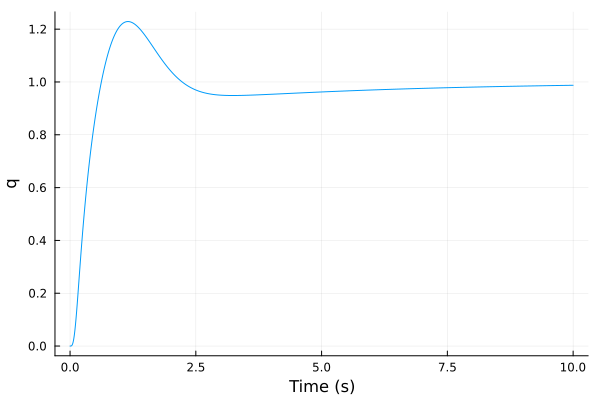

In [517]:
#steady-state error for a unit step input, now zero
L_q = series(C_q2e, P_e2q)
ε_q_cl = 1/(1+tf(L_q))
@show ε_q_cl(0)

T_q = output_comp_sensitivity(P_e2q, C_q2e) #this is the closed loop transfer function
T_q_step = step(T_q, t_sim_q)
stepinfo(T_q_step) |> display
T_q_step |> plot

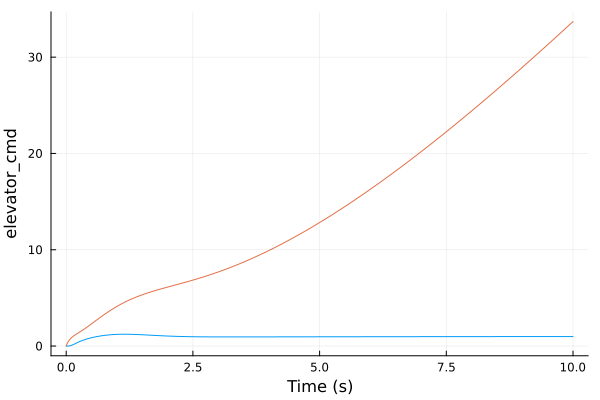

In [518]:
CS_q = G_CS(P_e2q, C_q2e)
CS_q_step = step(CS_q, t_sim_q)
CS_q_step |> plot!

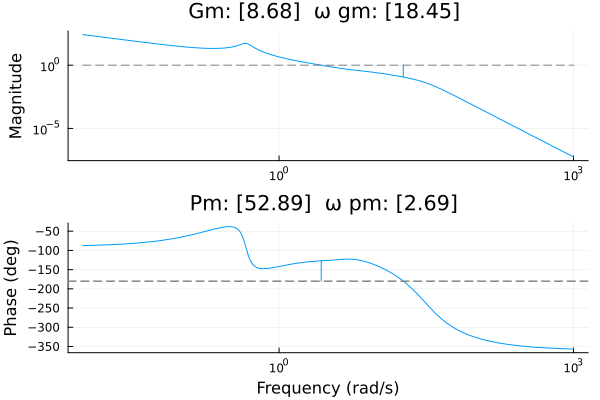

In [519]:
marginplot(L_q)

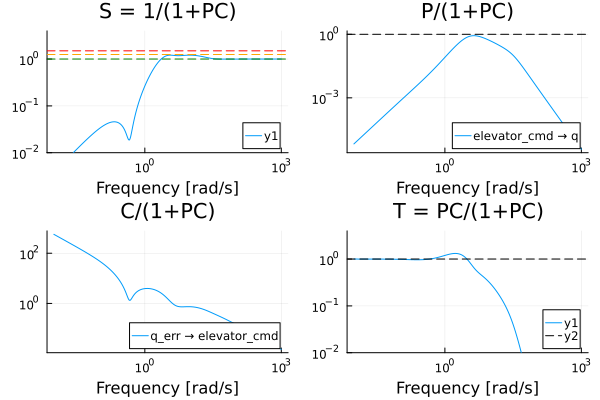

In [520]:
gangoffourplot(P_e2q, C_q2e)


Now we have a SISO compensator design, we need to use it to close the loop in the MIMO plant.

First, we will do it manually. The baseline MIMO system has two inputs, throttle_cmd and elevator_cmd. Our SISO compensator receives q_err as an input and outputs elevator_cmd. So the MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, must receive [throttle_cmd, q_err] as input and output [throttle_cmd, elevator_cmd]. Therefore, it must apply an unit gain to its first input throttle_cmd to let it pass through unchanged, and apply the SISO compensator to its second input q_err to obtain elevator_cmd.

The setpoint vector to be applied to the closed-loop MIMO system is r = [throttle_cmd, q_dmd]. The input to the MIMO compensator must be u = [throttle_cmd, q_err] = r - f = [throttle_cmd, q_dmd] - [0, q]. So we need a matrix gain that premultiplies the 7-component output vector of thr_ele_MIMO, and produces a 2-component vector [0, q]. This will be a 2xNy matrix K_q with all entries set to zero except K_q[2, 1] (the nonzero output goes in the second component, and it is q, the first element in thr_ele_MIMO's output vector)

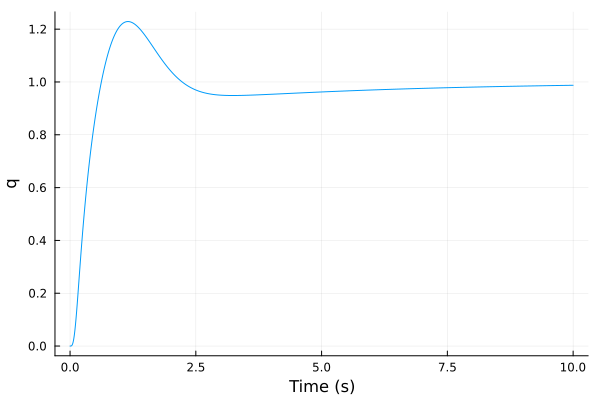

In [521]:
#create a diagonal MIMO system with a unit feedthrough system and the pitch
#rate compensator
C_q2e_MIMO = append(ss(1.0), ss(C_q2e))
#prepend it to the plant
C_q2e_thr_ele_MIMO = series(C_q2e_MIMO, ss(thr_ele_MIMO))

#construct feedback system K_q_ss
K_q = zeros(2, length(thr_ele_MIMO.y))
K_q[2,1] = 1 #selects q from thr_ele_MIMO and puts it in the second row
K_q_ss = ss(K_q) #creates a ss with no dynamics and K_q as feedthrough

#create a feedback loop with K_q_ss in the feedback path
thr_q_MIMO = feedback(C_q2e_thr_ele_MIMO, K_q_ss)

#finally, convert it to a NamedStateSpace with the appropriate labels
thr_q_MIMO = named_ss(thr_q_MIMO, :thr_q, u = [:throttle_cmd, :q_dmd], y = thr_ele_MIMO.y)

#check we get the same response as with the SISO closed loop
qdmd2q = thr_q_MIMO[:q, :q_dmd]
step(qdmd2q, t_sim_q) |> plot

All this is made much more straightforward by the connect function from RobustAndOptimalControl.jl

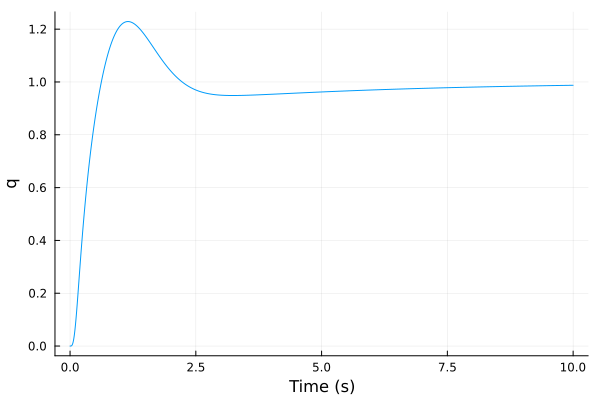

In [522]:
qsum = sumblock("q_err = q_dmd - q")
thr_q_MIMO = connect([qsum, C_q2e, thr_ele_MIMO], [:q_err=>:q_err, :q=>:q, :elevator_cmd=>:elevator_cmd], w1 = [:throttle_cmd, :q_dmd], z1 = thr_ele_MIMO.y)

#verify we get the same response as with the SISO closed loop
qdmd2q = thr_q_MIMO[:q, :q_dmd]
step(qdmd2q, t_sim_q) |> plot

#thr_q_MIMO is our new plant baseline: longitudinal dynamics with embedded pitch
#rate control and throttle_cmd and q_dmd as inputs
# thr_q_MIMO |> display

## 2. Pitch Angle

The starting plant is the longitudinal dynamics augmented with embedded pitch rate control, from which we extract the pitch rate demand to pitch angle response.

ε_q2θ_cl(0) = [6.834228810646922e-6;;]


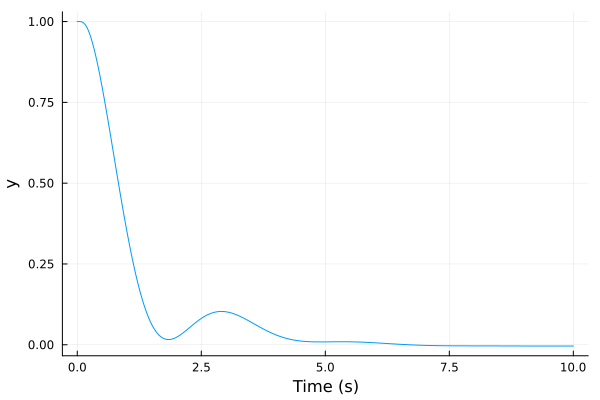

In [523]:
P_q2θ = thr_q_MIMO[:θ, :q_dmd]
#error transfer function for a unit feedback closed loop and a unit step input
ε_q2θ_cl = 1/(1+tf(P_q2θ))
@assert isstable(ε_q2θ_cl)
#final value theorem to find steady-state error
@show ε_q2θ_cl(0)
step(ε_q2θ_cl, 10) |> plot

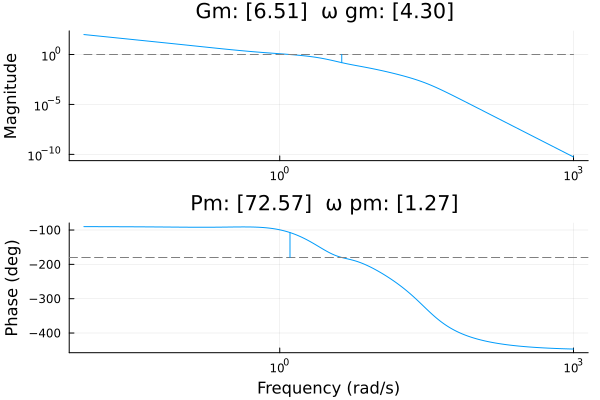

In [524]:
marginplot(P_q2θ)

Now we can optimize the compensator. Since this is already a type-1 system, we expect integral gain to be unnecessary for zero steady-state error. Therefore, we set its upper bound to zero.

In [525]:
t_sim_θ = 10
upper_bounds = PIDParams(; k_p = 50.0, k_i = 0.0, k_d = 5.0, τ_f = 0.01)
settings = PIDOpt.Settings(; t_sim = t_sim_θ, maxeval = 5000, upper_bounds)

weights = PIDOpt.Metrics(; Ms = 1.0, ∫e = 10.0, ef = 1.0, ∫u = 0.0, up = 0.0)

params_0 = PIDParams(; k_p = 2.0, k_i = 0.0, k_d = 0.0, τ_f = 0.01)

θ_results = PIDOpt.optimize_PID(P_q2θ; params_0, settings, weights, global_search = false)
θ_PID = PIDOpt.build_PID(θ_results.params)

@show θ_results.params.k_p
@show θ_results.params.k_i
@show θ_results.params.k_d
@show θ_results.params.T_i
@show θ_results.params.T_d
# θ_PID = PIDOpt.build_PID(PIDParams(; k_p = 4.29, k_i = 0.0, k_d = 0.673))

θ_results.params.k_p = 2.451769549322303
θ_results.params.k_i = 0.0
θ_results.params.k_d = 0.7703927691156788
θ_results.params.T_i = Inf
θ_results.params.T_d = 0.31421907875828875


0.31421907875828875

StepInfo:
Initial value:     0.000
Final value:       1.002
Step size:         1.002
Peak:              1.030
Peak time:         0.911 s
Overshoot:          2.85 %
Undershoot:         0.00 %
Settling time:     2.590 s
Rise time:         0.430 s


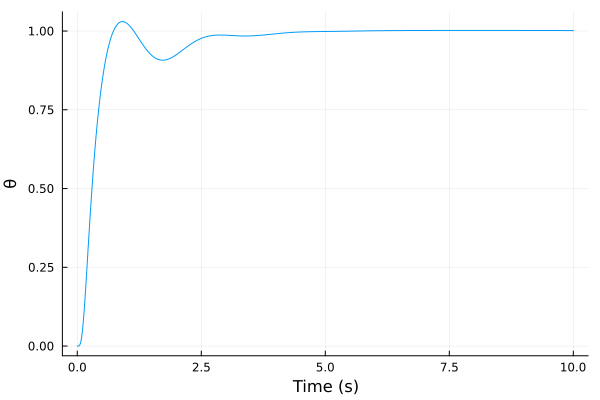

In [526]:
C_θ2q = θ_PID
C_θ2q = named_ss(ss(C_θ2q), :θcmp; u = :θ_err, y = :q_dmd)
T_θ = output_comp_sensitivity(P_q2θ, C_θ2q)
T_θ_step = step(T_θ, t_sim_θ)
stepinfo(T_θ_step) |> display
T_θ_step |> plot

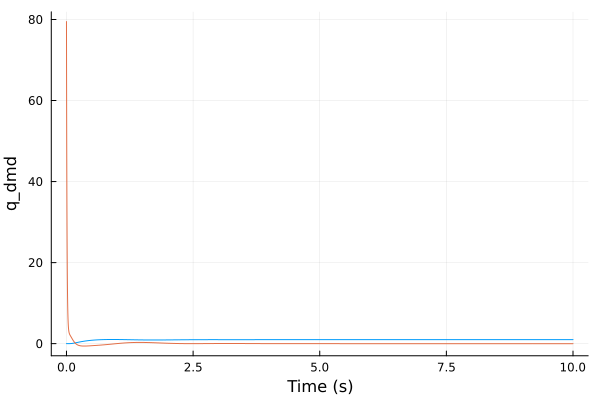

In [527]:
CS_θ = G_CS(P_q2θ, C_θ2q)
CS_θ_step = step(CS_θ, t_sim_θ)
CS_θ_step |> plot!

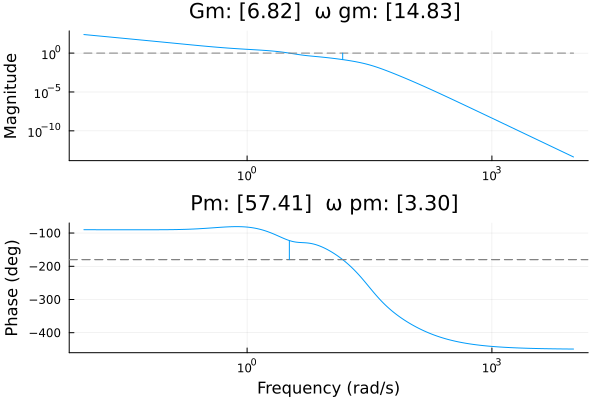

In [528]:
L_θ = series(C_θ2q, P_q2θ)
marginplot(L_θ)

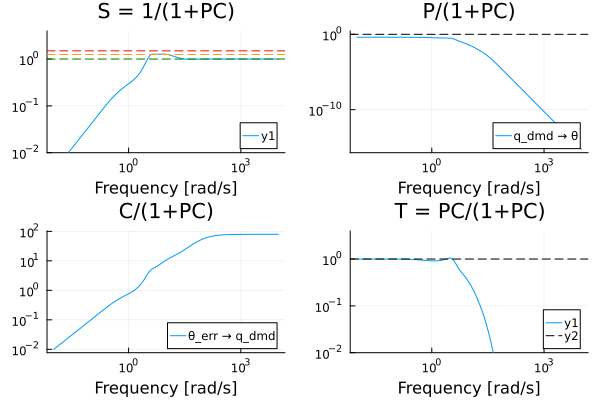

In [529]:
gangoffourplot(P_q2θ, C_θ2q)

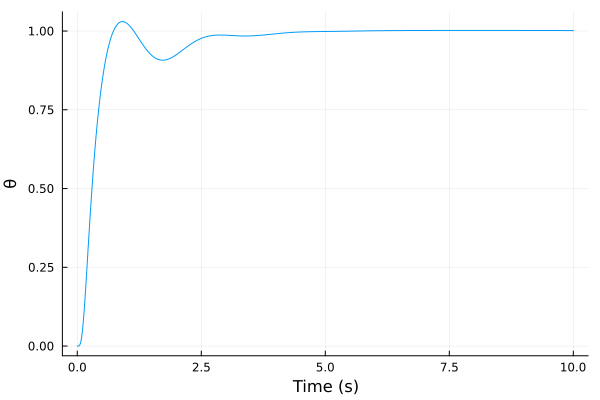

In [530]:
θsum = sumblock("θ_err = θ_dmd - θ")
thr_θ_MIMO = connect([θsum, C_θ2q, thr_q_MIMO], [:θ_err=>:θ_err, :θ=>:θ, :q_dmd=>:q_dmd], w1 = [:throttle_cmd, :θ_dmd], z1 = thr_q_MIMO.y)

#check we get the same response as with the SISO closed loop
θdmd2θ = thr_θ_MIMO[:θ, :θ_dmd]
step(θdmd2θ, t_sim_θ) |> plot

Our linear model comes from a horizontal, wings level flight condition, in which thetadot = q. However, in general we have q = ... where psi_dot = ...
Substituting the second equation into the first and solving for q we arrive at the following:
q(theta_dot, r, phi)
When we have nonzero r and phi (for example during a turn), it is clear that maintaining theta_dot = 0 requires nonzero q. Also, it is clear that as phi increases, the gain from thetadot to q decreases.
Since the theta controller design assumes q = theta_dot, the q_dmd output by the theta controller should actually be interpreted as theta_dot_dmd (or equivalently, the q_dmd we would need to track the desired theta in the absnce of r and phi)
The actual q_dmd required is thus given by:
q_dmd = 1/cos theta_dot dmd + r tan phi
What would happen during a turn if we don't introduce this feedforward correction? Since theta controller is purely proportional, it can only generate a nonzero output for nonzero theta error. Therefore, the necessary steady state q = r tan phi required by the turn can only be achieved by the theta controller through a nonzero steady state theta error. This means that turning would always produce a nonzero steady state theta error. The higher the turn rate, the larger the error.

## 3. TAS to $\theta$

In [531]:
P_θ2v = thr_θ_MIMO[:TAS, :θ_dmd]
zpk(P_θ2v)

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                       (1.0s + 49.65944542282121)(1.0s + 9.18635421836087)(1.0s^2 - 0.045561153402176896s + 12.015141512828576)(1.0s^2 + 4.520369198569574s + 20.203075371366314)(1.0s + 3.0843342218782057)(1.0s + 1.1738832352440574)
-2.772741137589267e6-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                    (1.0s + 100.07318292225565)(1.0s + 49.475501078391034)(1.0s^2 + 42.50137467538148s + 1009.8406270299874)(1.0s + 9.204992879946225)(1.0s^2 + 13.812066094585067s + 74.88474320490442)(1.0s + 3.2487292594519825)(1.0s^2 + 2.6842947167454025s + 13.5759489168885)(1.0s + 0.6571816001514892)(1.0s +

Negative DC gain!

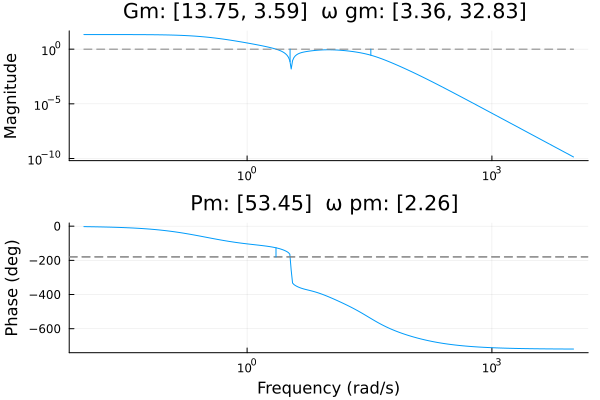

In [532]:
zpk(P_θ2v)
step(P_θ2v, 10) |> plot
marginplot(-0.5*P_θ2v)

## CONTINUE HERE

## 4. TAS to Throttle

We can reasonably assume that autothrottle will be used together with some form of $\theta$ control, be it manual or automatic. Thus, we start from the plant with closed-loop $\theta$ control. This scenario corresponds for example to the pitch angle, climb rate and altitude hold modes, in which automatic $\theta$ control will be enabled, with $\theta$ demands supplied either directly or by the climb rate loop.

In [533]:
t2v = thr_θ_MIMO[:TAS, :throttle_cmd]

zpk(t2v) |> display
poles(t2v) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                   (1.0s + 100.08214644425924)(1.0s + 48.8666490827761)(1.0s^2 + 43.43134648954697s + 1023.9305268401228)(1.0s^2 + 13.886942591197398s + 102.48687760309087)(1.0s^2 + 2.5152211596563503s + 12.62148460049099)(1.0s + 2.8345174111053058)(1.0s + 0.7416787616344193)
30522.69301031163----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 100.07318292225567)(1.0s + 49.47550107839104)(1.0s^2 + 42.5013746753815s + 1009.8406270299868)(1.0s^2 + 37.6991118430775s + 986.9604401089355)(1.0s + 9.204992879946202)(1.0s^2 + 13.812066094585004

14-element Vector{ComplexF64}:
  -100.07318292225567 + 0.0im
   -49.47550107839104 + 0.0im
   -21.25068733769075 + 23.62729173446878im
   -21.25068733769075 - 23.62729173446878im
   -6.906033047292502 + 5.214542238261035im
   -6.906033047292502 - 5.214542238261035im
   -9.204992879946202 + 0.0im
  -1.3421473583727241 + 3.4314121561394466im
  -1.3421473583727241 - 3.4314121561394466im
   -3.248729259451933 + 0.0im
  -0.6571816001514538 + 0.0im
 -0.25698427908440813 + 0.0im
   -18.84955592153875 + 25.132741228718345im
   -18.84955592153875 - 25.132741228718345im

In [534]:
#error transfer function for a unit feedback closed loop and a unit step input
ε_t2v_cl = 1/(1+tf(t2v))
@assert isstable(ε_t2v_cl)
#all closed loop poles are stable, final value theorem
@show ε_t2v_cl(0)

ε_t2v_cl(0) = [0.057453883588243805;;]


1×1 Matrix{Float64}:
 0.057453883588243805

ε_vtcmp_t2v_cl(0) = [0.0;;]


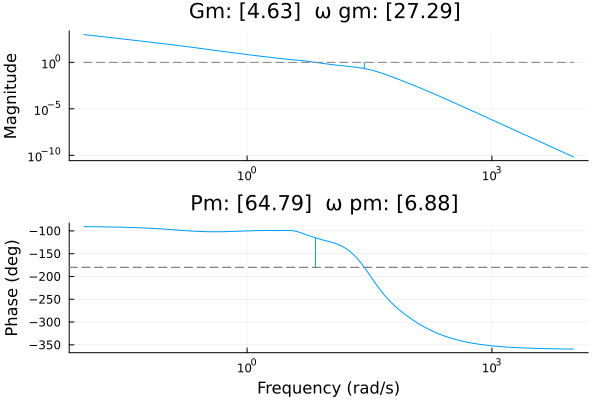

In [535]:
#we don't want the response to be too eager. and in theory we should only need a
#smidge of integration to get rid of steady state error. however, in simulation
#we find that the integrator needs some more punch to reject the effects of
#altitude changes, etc

k_p_vt = 1.8
k_i_vt = 0.6
k_d_vt = 0.2
τ_d_vt = 0.01

vtcmp_tf = k_p_vt + k_i_vt * tf(1, [1,0]) + k_d_vt * tf([1, 0], [τ_d_vt, 1])

#input to the theta compensator is TAS error, output is throttle_cmd
vtcmp = named_ss(ss(vtcmp_tf), :vtcmp; u = :TAS_err, y = :throttle_cmd)
vtcmp_t2v = series(vtcmp, t2v)

#unit feedback steady-state error for a unit step input, now zero
ε_vtcmp_t2v_cl = 1/(1+tf(vtcmp_t2v))
@show ε_vtcmp_t2v_cl(0)

marginplot(vtcmp_t2v)

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.027
Peak time:         0.466 s
Overshoot:          2.71 %
Undershoot:         0.00 %
Settling time:     1.472 s
Rise time:         0.183 s


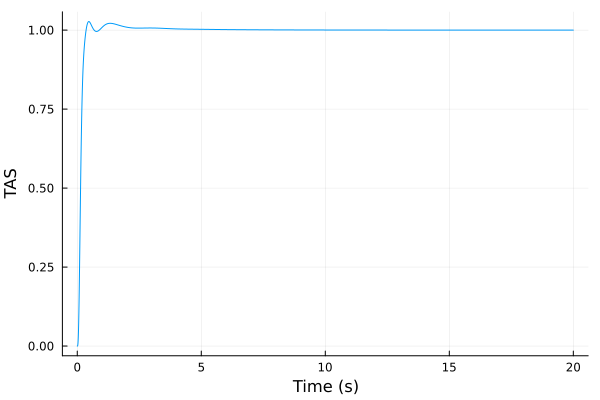

In [536]:
vtcmp_t2v_cl = feedback(vtcmp_t2v)
vtcmp_t2v_cl_step = step(vtcmp_t2v_cl, 20)

# poles(minreal(θcmp_qdmd2θ_cl, 1e-3)) |> display
stepinfo(vtcmp_t2v_cl_step) |> display
vtcmp_t2v_cl_step |> plot

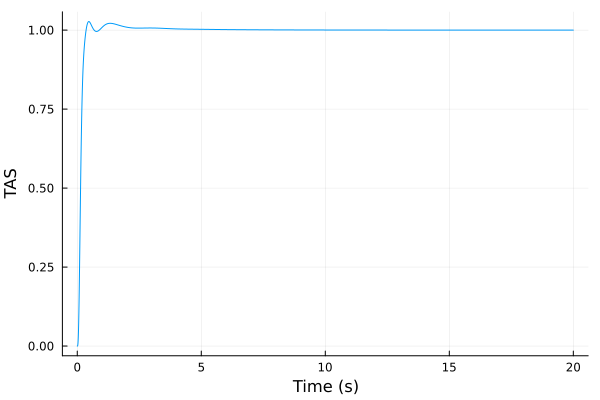

In [537]:
TASsum = sumblock("TAS_err = TAS_dmd - TAS")
vt_θ_MIMO = connect([TASsum, vtcmp, thr_θ_MIMO], [:TAS_err=>:TAS_err, :TAS=>:TAS, :throttle_cmd=>:throttle_cmd], w1 = [:TAS_dmd, :θ_dmd], z1 = thr_θ_MIMO.y)

#check we get the same response as with the SISO closed loop
TASdmd2TAS = vt_θ_MIMO[:TAS, :TAS_dmd]
step(TASdmd2TAS, 20) |> plot

## Linear vs Simulation Response Tests

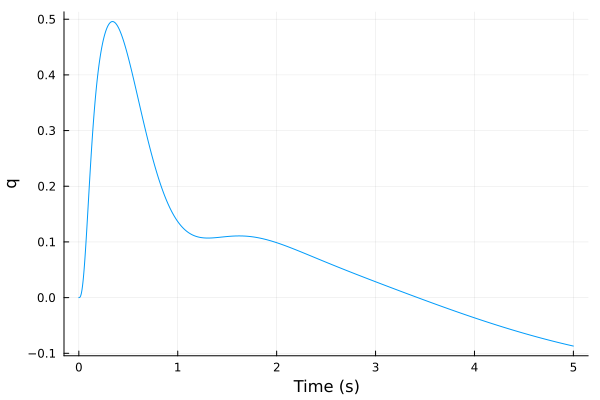

In [538]:
P_e2α = thr_ele_MIMO[:α, :elevator_cmd]
P_e2fz = thr_ele_MIMO[:f_z, :elevator_cmd]
step(P_e2q, 5) |> plot
# step(P_e2fz, 5) |> plot

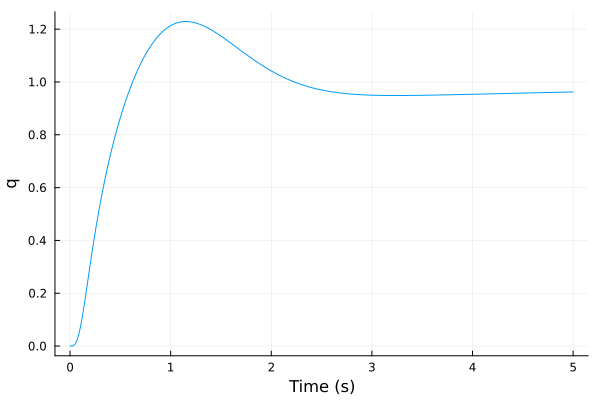

In [539]:
P_qdmd2q = thr_q_MIMO[:q, :q_dmd]
step(P_qdmd2q, 5) |> plot

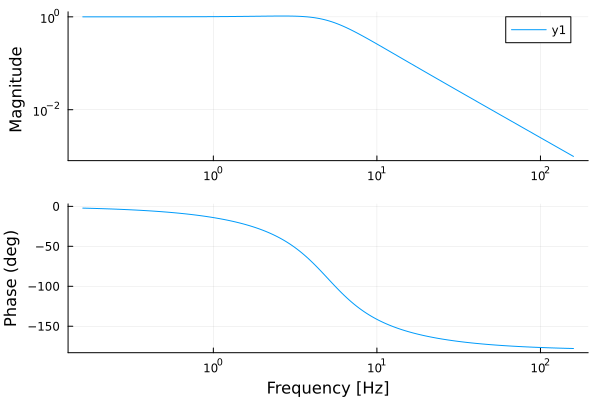

In [540]:
    ω_n::Float64 = 5*2π #natural frequency (default: 10 Hz)
    ζ::Float64 = 0.6 #damping ratio (default: underdamped with minimal resonance)
act = tf(ω_n^2, [1, 2ζ*ω_n, ω_n^2])
bodeplot(act, hz = true)